# Real-Time TDDFT 
**by <span style="color:darkgreen">Ronaldo Rodrigues Pela</span> for [<span style="color:darkgoldenrod">exciting *neon*</span>](https://www.exciting-code.org/neon)**

<font size="2">(Jupyter notebook by <span style="color:darkgreen">Mara Voiculescu</span> and <span style="color:darkgreen">Martin Kuban</span>)</font>
<hr style="border:2px solid #DDD"> </hr>

**<span style="color:firebrick">Purpose</span>**: In this tutorial, you will learn how to perform an ilustrative real-time time-dependent density-functional theory (**RT-TDDFT**) calculation. We consider diamond as an example.

<hr style="border:2px solid #DDD"> </hr>

<div class="alert alert-block alert-warning">
    
**Table of Contents**

[0. Before Starting](#0)
    
[1. Theoretical Background for RT-TDDFT Calculation](#1)
        
[2. Ground-State Calculation](#2)
    
  - [Preparation of the Input File](#2)
  - [Running the Ground-State Calculation](#2.1)
    
[3. Performing a RT-TDDFT Calculation](#3)
    
  - [Setting Elements and Attributes](#3)
  - [Running exciting](#3.1)
    
[4. Visualizing the Output](#4)
    
[5. Converging the Results](#5)

[6. Other Expressions for the Laser Field](#6)
      
  - [Impulsive Function](#6)
  - [Cosine Modulated by a sin Squared](#6.1)
  - [Combining Fields](#6.2)
    
[Reference](#7)

</div>

<a id='0'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">0. Before Starting</span>

**<span style="color:firebrick">Read the following paragraphs before starting with the rest of this tutorial!</span>**

Before running any Jupyter tutorials, please refer to the **`00_before_starting.md`** document on how to correctly set up the environment. This only needs to be done once. After which, the **venv** can be (re)activated from **`exciting`**'s root directory:

<div style="background-color: rgb(224, 224, 224);">

```bash
source tools/excitingjupyter/venv/excitingvenv/bin/activate
```

</div>


**<span style="color:firebrick">Important note:</span>** All input parameters that will appear will be given in **atomic units**! For this tutorial, it can be useful to remind the conversion between a.u. and the SI for times: 1 a.u. = 0.02418884254 fs.

<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">1. Theoretical Background for RT-TDDFT Calculation</span>

In **TDDFT**, we consider a system of electrons submitted to an external time-dependent (**TD**) perturbation, expressed usually in terms of an applied electric field $\mathbf{E}(t)$. This leads to a **TD** Kohn-Sham (**KS**) hamiltonian $\hat{H}(\mathbf{r},t)$:

\begin{equation}
\tag{1}
\hat{H}(\mathbf{r},t) = \frac{1}{2}\left(-\mathrm{i}\nabla + \frac{1}{c}\mathbf{A}(t)\right)^{\!\!2} + v^\phantom{I}_\textrm{KS}(\mathbf{r},t),
\end{equation}

where $\mathbf{A}(t)$ is the vector potential $\mathbf{A}(t)=-c\int_0^t \mathbf{E}(t')\,dt'$, $c$ is the speed of light, and $v^\phantom{I}_\textrm{KS}(\mathbf{r},t)$ is the **TD-KS** potential, a sum of the **TD** ionic, Hartree and exchange-correlation (**XC**) potentials. We assume in **`exciting`** the adiabatic approximation for the **TD-XC** potential: $v^\phantom{I}_\textrm{XC}(\mathbf{r},t)$ is constructed using $n(\mathbf{r},t)$, the **TD** electronic density, the same way that $v^\phantom{I}_\textrm{XC}(\mathbf{r},0)$ in the ground-state is constructed from the ground-state density $n(\mathbf{r},0)$.


A **KS** wavefunction $\psi_{j\mathbf{k}}(\mathbf{r},t)$ labeled with index $j$ and associated to a wavevector **k** evolves as

\begin{equation}
\tag{2}
| \psi_{j\mathbf{k}}(t+\Delta t)\rangle = \hat{U}(t+\Delta t,t)\,| \psi_{j\mathbf{k}}(t)\rangle,
\end{equation}

where the propagator $\hat{U}(t+\Delta t,t)$ is given by:

\begin{equation}
\tag{3}
\hat{U}(t+\Delta t,t) = \hat{\mathcal{T}}\left[ \exp\left( -\mathrm{i}\int_t^{t+\Delta t} \mathrm{d}\tau\, \hat{H}(\tau) \right) \right],
\end{equation}

$\hat{\mathcal{T}}$ being the time-ordering operator. The following propagators are implemented:

- simple exponential,
- exponential at midpoint rule,
- approximate enforced time-reversal symmetry,
- Commutator-Free Magnus expansion of 4th order,
- exponential using a basis of the hamiltonian-eigenvectors, and
- Runge-Kutta of 4th order.

Please refer to **[<span style="color:firebrick">Ref.[1]</span>](#7)** for the expressions of $\hat{U}(t+\Delta t,t)$.

As consequence of the exciting electric field, electrons are moved away from their equilibrium position. This gives origin to a macroscopic current density $\mathbf{J}(t)$, which for local and semilocal **KS** functionals, can be obtained as

\begin{equation}
\tag{4}
\mathbf{J}(t) = \frac{\mathrm{i}}{\Omega}\sum_{j\mathbf{k}}w_{\mathbf{k}}f_{j\mathbf{k}} \left\langle \psi_{j\mathbf{k}}(t) \big|\nabla \big|\psi_{j\mathbf{k}}(t)\right\rangle -\frac{N\mathbf{A}(t)}{c\,\Omega},
\end{equation}

where $N$ stands for the number of valence electrons in the unit cell with volume $\Omega$, $w_{\mathbf{k}}$ is the weight of the considered **k-point**, and $f_{j\mathbf{k}}$ is the occupation number of the corresponding **KS** state.

Another quantity of interest is the number of excited electrons (per unit cell) $N_\textrm{exc} (t)$ at a given time. It is possible to describe them by projecting $| \psi_{i\mathbf{k}}(t)\rangle$ onto the ground state wavefunctions. For a given **k-point**, the number of electrons that have been excited to an unoccupied **KS** state, labeled with $j$, is

\begin{equation}
\tag{5}
m^e_{j\mathbf{k}} (t)= \sum_{i} f_{i\mathbf{k}}\, | \langle \psi_{j\mathbf{k}}(0) | \psi_{i\mathbf{k}}(t)\rangle |^2,
\end{equation}

whereas the number of holes created in an occupied **KS** state $j′$ is

\begin{equation}
\tag{6}
m^h_{j'\mathbf{k}} (t)= f_{j'\mathbf{k}} - \sum_{i} f_{i\mathbf{k}}\, | \langle \psi_{j'\mathbf{k}}(0) | \psi_{i\mathbf{k}}(t)\rangle |^2.
\end{equation}

Thus, $N_\textrm{exc} (t)$ can be obtained by considering all the unoccupied states

\begin{equation}
\tag{7}
N_\textrm{exc}(t)= \sum_{j\mathbf{k}}^{j\, \textrm{unocc}} w_\mathbf{k}\, m^e_{j\mathbf{k}} (t) = \sum_{j'\mathbf{k}}^{j'\, \textrm{occ}} w_\mathbf{k}\, m^h_{j'\mathbf{k}} (t) .
\end{equation}

<a id='2'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">2. Ground-State Calculation</span>

**<span style="color:#15317E">i) Preparation of the Input File</span>**

The first step is to create a directory for the system that we want to investigate, **run_diamond_rt**

In [1]:
%%bash
mkdir -p run_diamond_rt

As initial condition for the time evolution done in **RT-TDDFT**, we need the electron density and potential from a ground-state calculation. Therefore, we create the file **input.xml** that could look like the following:

<span class="DIAMOND_RT_TDDFT"></span>
```xml
<input>
 
   <title>Diamond</title>
 
   <structure speciespath="$EXCITINGROOT/species/">
      <crystal scale="6.7407">
         <basevect>0.0 0.5 0.5</basevect>
         <basevect>0.5 0.0 0.5</basevect>
         <basevect>0.5 0.5 0.0</basevect>
      </crystal>
      <species speciesfile="C.xml" rmt="1.4">
         <atom coord="0.00 0.00 0.00"/>
         <atom coord="0.25 0.25 0.25"/>
      </species>
   </structure>
 
   <groundstate
      do="fromscratch"
      xctype="LDA_PW"
      ngridk="8 8 8"
      rgkmax="5.0d0"
      nempty="5"
      epsengy="1.d-8">
   </groundstate>   
 
</input>
```

In [2]:
import os
from excitingjupyter.utilities import get_input_xml_from_notebook   

# Extract input file content from this notebook:
input_str = get_input_xml_from_notebook("02_tutorial_real_time_tddft", "DIAMOND_RT_TDDFT")

# Write out the input as an XML file:
with open('./run_diamond_rt/input.xml', "w") as fid:
    fid.write(input_str)

Do not forget to replace in the **input.xml** the actual value of the environment variable **$EXCITINGROOT**. You can do this by directly editing the **input.xml** file or by using the following command:

In [3]:
%%bash
cd run_diamond_rt
python3 -m excitingscripts.setup.excitingroot
cd ..

<a id='2.1'></a>
**<span style="color:#15317E">ii) Running the Ground-State Calculation</span>**

You can start the calculation by invoking the script **`excitingscripts.execute.single`**.

In [4]:
%%bash
python3 -m excitingscripts.execute.single -r run_diamond_rt

You can check the bunch of files created during the run, especially the main output file **INFO.OUT**, for convergence information. If the calculation of the ground state has been finished successfully, in the last lines of the **INFO.OUT** file you should find the message
    
```
...
================================================================================
| EXCITING NEON stopped                                                        =
================================================================================
```

Check if the calculation finishes gracefully and if the **EFERMI.OUT** and **STATE.OUT** files are present. These files contain the **<span style="color:green">Fermi level</span>** and the converged **<span style="color:green">electron density and potential</span>**, respectively, and are the starting point of the **RT-TDDFT** calculation.

**<span style="color:firebrick">Please note</span>**: To obtain reliable results it is necessary to perform careful convergence tests with respect to the **k**-point mesh (parameter <code><span style="color:mediumblue">ngridk</span></code>) and the size of the basis set (parameter <code><span style="color:mediumblue">rgkmax</span></code>). For details see the tutorial **Simple convergence tests**.

<a id='3'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">3. Performing a RT-TDDFT Calculation</span>

**<span style="color:#15317E">i) Setting Elements and Attributes</span>**

You can prepare the input file (**input.xml**) of a **RT-TDDFT** calculation starting from the existing ground-state input file. The explicit ground-state calculation can be avoided with the attribute <code><span style="color:mediumblue">do</span>=<span style="color:firebrick">"skip"</span></code> inside the element <code><span style="color:green">groundstate</span></code>.

```xml
...
   <groundstate 
      do="skip"
      ... >
      ...
   </groundstate>
...

```
In order to perform a **"RT-TDDFT"** calculation, the element <code><span style="color:green">xs</span></code>, must be added to the input file inside the <code><span style="color:green">input</span></code> element, as shown below.

```xml
...
   <xs 
      xstype="RT-TDDFT"
      ngridk="4 4 4"
      rgkmax="5.0d0"
      vkloff="0.01 0.02 0.004"
      nempty="5"
      nosym="true"
      reducek="false">
      <realTimeTDDFT
         propagator="AETRS"
         timeStep="0.25d0"
         endTime="50.d0"
         printTimingGeneral="true"
         calculateNExcitedElectrons="true"
         printAfterIterations="1">
         <laser>
            <trapCos 
               amplitude="1.0d0" omega="1.0d0" phase="0.d0"
               t0="0.25d0" riseTime="5.d0" width="30.d0" 
               direction="x" />
         </laser>
         <pmat readFromFile="false" writeToFile="false" forceHermitian="false" />
      </realTimeTDDFT>
   </xs>
...

```

In [5]:
# The following lines modify the input.xml using Python
from excitingtools import ExcitingInputXML, ExcitingXSInput

parsed_input = ExcitingInputXML.from_xml('./run_diamond_rt/input.xml')

xs = {'xstype': 'RT-TDDFT',
      'ngridk': [4, 4, 4],
      'rgkmax': 5.0,
      'vkloff': [0.01, 0.02, 0.004],
      'nempty': 5,
      'nosym': True,
      'reducek': False,
      'realTimeTDDFT': {'propagator': 'AETRS', 'timeStep': 0.25, 'endTime': 50.0, 'printTimingGeneral': True,
                        'calculateNExcitedElectrons': True, 'printAfterIterations': 1,
                        'pmat': {'readFromFile': False, 'writeToFile': False, 'forceHermitian': False},
                        'laser': {'trapCos': [{'amplitude': 1.0, 'omega': 1.0, 'phase': 0.0, 't0': 0.25,
                                               'riseTime': 5.0, 'width': 30.0, 'direction': 'x'}]}}}

parsed_input.xs = ExcitingXSInput(**xs)
parsed_input.groundstate.do = "skip"

parsed_input.write('./run_diamond_rt/input.xml')

These settings in the input file correspond to a calculation with the following main features:
- It is a **RT-TDDFT** calculation (the attribute <code><span style="color:mediumblue">xstype</span></code> is set to <code><span style="color:firebrick">"RT-TDDFT"</span></code>).
- The attribute <code><span style="color:mediumblue">ngridk</span></code> inside the <code><span style="color:green">xs</span></code> element determines the **k-grid** used for the **KS** wavefunctions $| \psi_{i\mathbf{k}}(t)\rangle$ evolved as given by Eq. (2). This **k-grid** is also affected by <code><span style="color:mediumblue">vkloff</span></code> inside <code><span style="color:green">xs</span></code>, which, in turn, specifies an offset (given in lattice coordinates) for the grid generation. Additionally, <code><span style="color:mediumblue">nosym</span>=<span style="color:firebrick">"true"</span></code> and <code><span style="color:mediumblue">reducek</span>=<span style="color:firebrick">"false"</span></code> inside <code><span style="color:green">xs</span></code> enforce that no symmetry and no k-point reduction is to be used (**[<span style="color:firebrick">Ref.[2]</span>](#7)**).
- <code><span style="color:mediumblue">rgkmax</span></code> inside <code><span style="color:green">xs</span></code> determines the size of the basis for the expansion used for $| \psi_{i\mathbf{k}}(t)\rangle$.
- The attribute <code><span style="color:mediumblue">nempty</span></code> inside <code><span style="color:green">xs</span></code> specifies the number of unoccupied states also considered in the time-evolution in Eq. (2). 
  - The attributes <code><span style="color:mediumblue">ngridk</span></code>, <code><span style="color:mediumblue">rgkmax</span></code>, <code><span style="color:mediumblue">vkloff</span></code>, <code><span style="color:mediumblue">nempty</span></code>, <code><span style="color:mediumblue">nosym</span></code>, and <code><span style="color:mediumblue">reducek</span></code> given in the <code><span style="color:green">xs</span></code> element are independent of their counterparts inside the <code><span style="color:green">groundstate</span></code> element.
  - Before evolving **KS** wavefunctions, a one-step ground-state calculation is carried out using <code><span style="color:mediumblue">ngridk</span></code>, <code><span style="color:mediumblue">rgkmax</span></code>, <code><span style="color:mediumblue">vkloff</span></code>, <code><span style="color:mediumblue">nempty</span></code>, <code><span style="color:mediumblue">nosym</span></code>, and <code><span style="color:mediumblue">reducek</span></code> given inside <code><span style="color:green">xs</span></code>.
  - However, the saved electronic density and the **KS** potential from **STATE.OUT**, used for this one-step calculation, had been obtained beforehand using the parameters <code><span style="color:mediumblue">ngridk</span></code>, …, <code><span style="color:mediumblue">reducek</span></code> inside the <code><span style="color:green">groundstate</span></code> element.
- The element <code><span style="color:green">realTimeTDDFT</span></code> determines the specific parameters for the **RT-TDDFT** calculation. 
  - Here, we consider a propagator an expression which approximately enforces time-reversal symmetry (<code><span style="color:mediumblue">propagator</span>=<span style="color:firebrick">"AETRS"</span></code>), with time-step of 0.25 atomic units (a.u.), <code><span style="color:mediumblue">timeStep</span>=<span style="color:firebrick">"0.25d0"</span></code>, and the time evolution is carried out up to the end time of 50 a.u. (<code><span style="color:mediumblue">endTime</span>=<span style="color:firebrick">"50.d0"</span></code>).
  - The meaning of <code><span style="color:mediumblue">calculateNExcitedElectrons</span>=<span style="color:firebrick">"true"</span></code> is to trigger the calculation of the number of the excited electrons. They are printed out in the file **NEXC.OUT**.
  - <code><span style="color:mediumblue">printTimingGeneral</span>=<span style="color:firebrick">"true"</span></code> triggers the measurement of the timings during the execution of the subroutines called in the **RT-TDDFT** calculation. The file **TIMING_RTTDDFT.OUT** stores such information. More detailed information is available adding <code><span style="color:mediumblue">printTimingDetailed</span>=<span style="color:firebrick">"true"</span></code>.
  - The element <code><span style="color:green">laser</span></code> describes the external field applied to the system. Here we consider a cosine modulated by a trapezoid, as given in the element <code><span style="color:green">trapCos</span></code>. The expression for the corresponding vector potential is
  
      \begin{equation}
      \tag{7}
      \mathbf{A}(t) = \mathbf{A}_0\, f(t) \cos ( \omega t + \phi )
      \end{equation}

      where $f(t)$ is the trapezoidal function: 

      \begin{equation}
      \tag{8}
      f(t) = \left\{ \begin{array}{ll} 0 & t \le t_0 \quad\mbox{ or }\quad t \ge t_0 + w + 2 t_r \\ 1 & t_0 + t_r \le t \le t_0 + t_r + w \\ (t-t_0)/t_r & t_0 < t < t_0 + t_r \\ (t_0 + w + 2 t_r - t )/t_r & t_0 + t_r + w < t < t_0 + w + 2 t_r \end{array} \right.
      \end{equation} 

      which is illustrated in the following figure.
      
      <figure>
      <img src=" 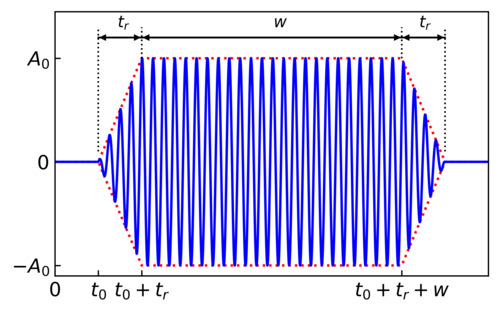" width="500" align="left"/>
      </figure>

   - In our example, the field has an amplitude of 1.0 a.u. (<code><span style="color:mediumblue">amplitude</span>=<span style="color:firebrick">"1.0d0"</span></code>) and is applied along the x-direction (<code><span style="color:mediumblue">direction</span>=<span style="color:firebrick">"x"</span></code>). The cosine function has an angular frequency of $\omega = 1.0$ a.u. (<code><span style="color:mediumblue">omega</span>=<span style="color:firebrick">"1.0d0"</span></code>") and phase $\phi=0.0$ (<code><span style="color:mediumblue">phase</span>=<span style="color:firebrick">"0.d0"</span></code>). The trapezoid function has parameters: initial time $t_0=0.25$ a.u., rise time of $t_r=5.0$ a.u., and width of $w=30$ a.u. (as given by: <code><span style="color:mediumblue">t0</span>=<span style="color:firebrick">"0.25d0"</span></code>, <code><span style="color:mediumblue">riseTime</span>=<span style="color:firebrick">"5.d0"</span></code>, <code><span style="color:mediumblue">width</span>=<span style="color:firebrick">"30.d0"</span></code>).
      
You can check all relevant parameters for a **"RT-TDDFT"** calculation in **[Input Reference](https://www.exciting-code.org/home/about/input-reference)**.

<a id='3.1'></a>
**<span style="color:#15317E">ii) Running exciting</span>**

Having modified the input file as described above, you can launch the **RT-TDDFT** calculation using the following command.

In [6]:
%%bash
python3 -m excitingscripts.execute.single -r run_diamond_rt

Be aware that, depending on the computer you are using, this calculation may take some minutes.

In our example, the one-step calculation performed before the evolution of the **KS** wavefunctions generates output files ending with **_RTTDDFT.OUT**. They contain the same information as their counterparts generated within a usual self-consistent cycle triggered by the <code><span style="color:green">groundstate</span></code> element. The only exception is **TIMING_RTTDDFT.OUT**, which has the timings required to execute different subroutines invoked in the evolution of **KS** wavefunctions.
Other output files generated specifically by the **RT-TDDFT** calculations are:

- **JIND.OUT**: with the three components of the current density. The time is written in the first column, and the next three columns contain the $x$, $y$ and $z$ components of the current density.
- **PVEC.OUT**, into where the polarization vector is written. The convention for the four columns is the same of **JIND.OUT**.
- **AVEC.OUT**, which contains the vector potential. The time is written in the first column, and the next six columns contain the $x$, $y$ and $z$ components of the induced and the total vector fields in the following order: $A_{\textrm{ind},x}$, $A_x$, $A_{\textrm{ind},y}$, $A_y$, $A_{\textrm{ind},z}$, $A_z$ (see **[<span style="color:firebrick">Ref.[4]</span>](#7)**).
- **NEXC.OUT**, where you find the number of excited electrons per unit cell. The first column contains the time; the second, the number of electrons per unit cell on the ground state; the third, the number of excited electrons per unit cell; the fourth, the sum of the previous two columns.


<a id='4'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">4. Visualizing the Outputs</span>

To visualize the current density, type the following command inside the running directory:

In [12]:
%%bash
cd run_diamond_rt
python3 -m excitingscripts.plot.multitask --jind -f JIND.OUT --x --plot_name JIND
cd ..

This plots the **x** component of the current density **[<span style="color:firebrick">[3]</span>](#7)**. The plot is saved in the running directory as **JIND.png**. Your figure should be similar to the following one:

<figure>
<img src=" 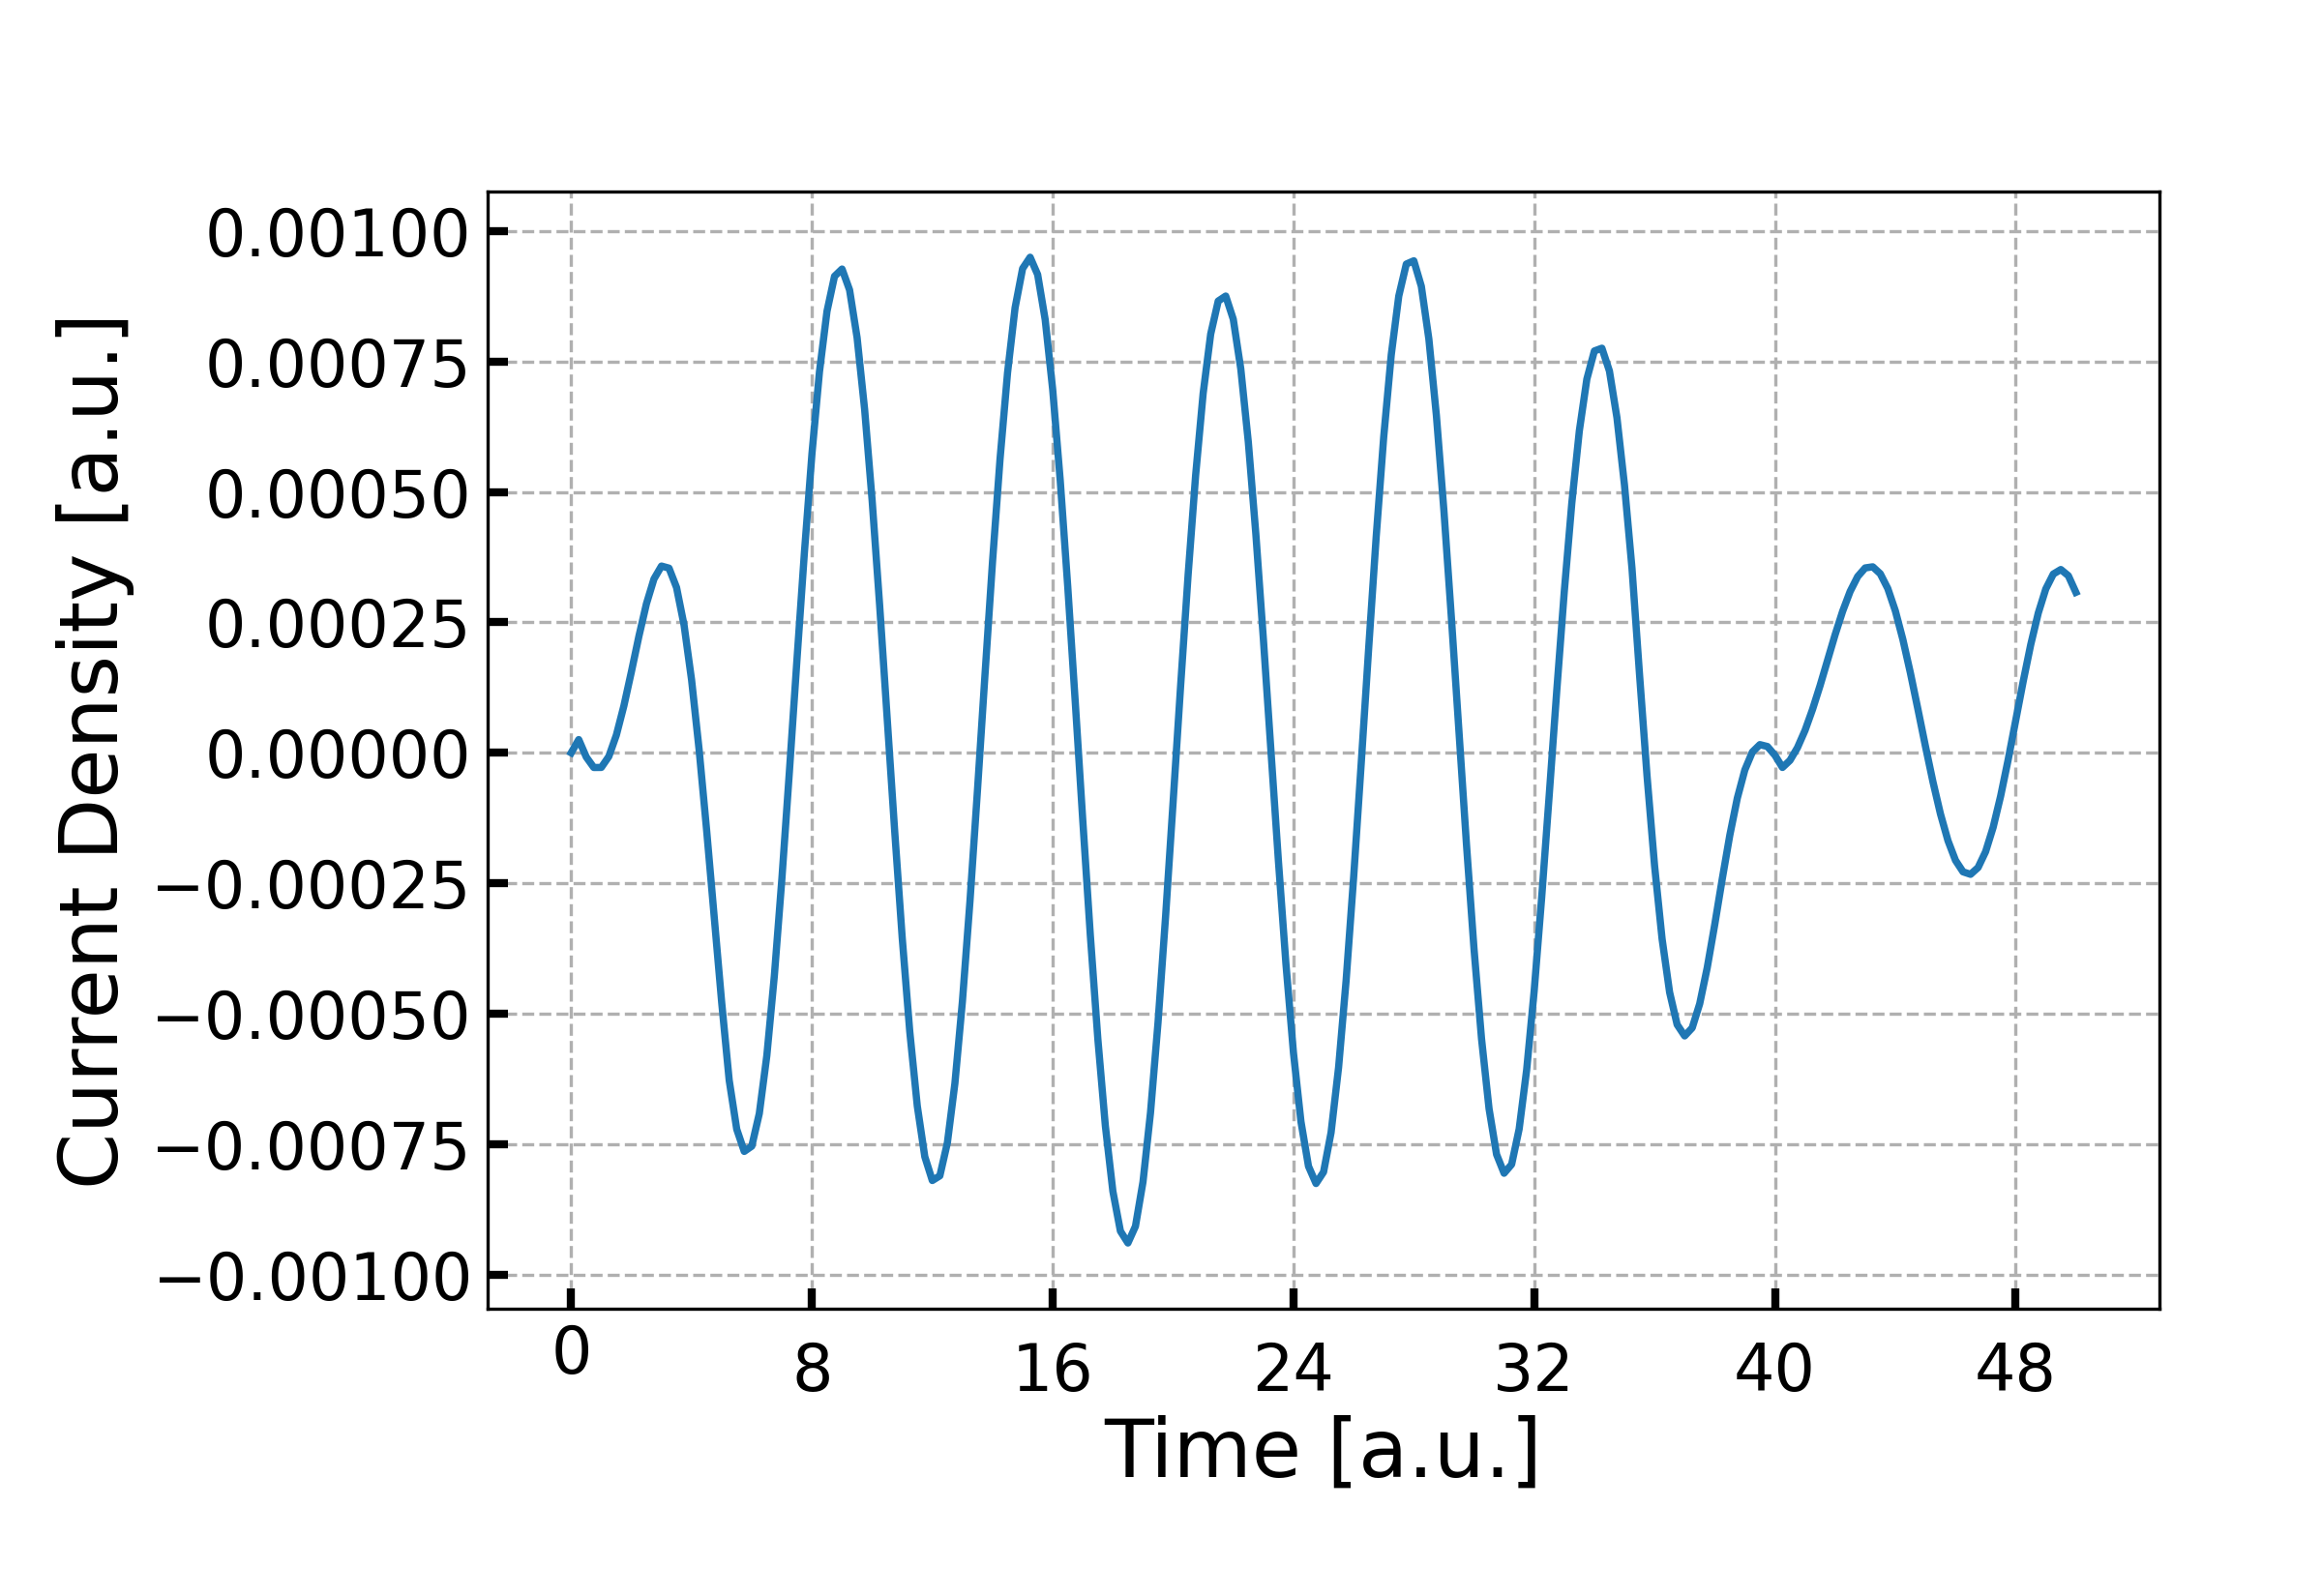" width="500" align="left"/>
</figure>

By using the command

In [14]:
%%bash
cd run_diamond_rt
python3 -m excitingscripts.plot.multitask --nexc -f NEXC.OUT --plot_name NEXC
cd ..

you can plot the number of excited electrons per unit cell, $N_\textrm{exc}(t)$, as a function of time. The plot is saved in the running directory as **NEXC.png**. Bellow, we show how your plot is expected to be:

<figure>
<img src=" 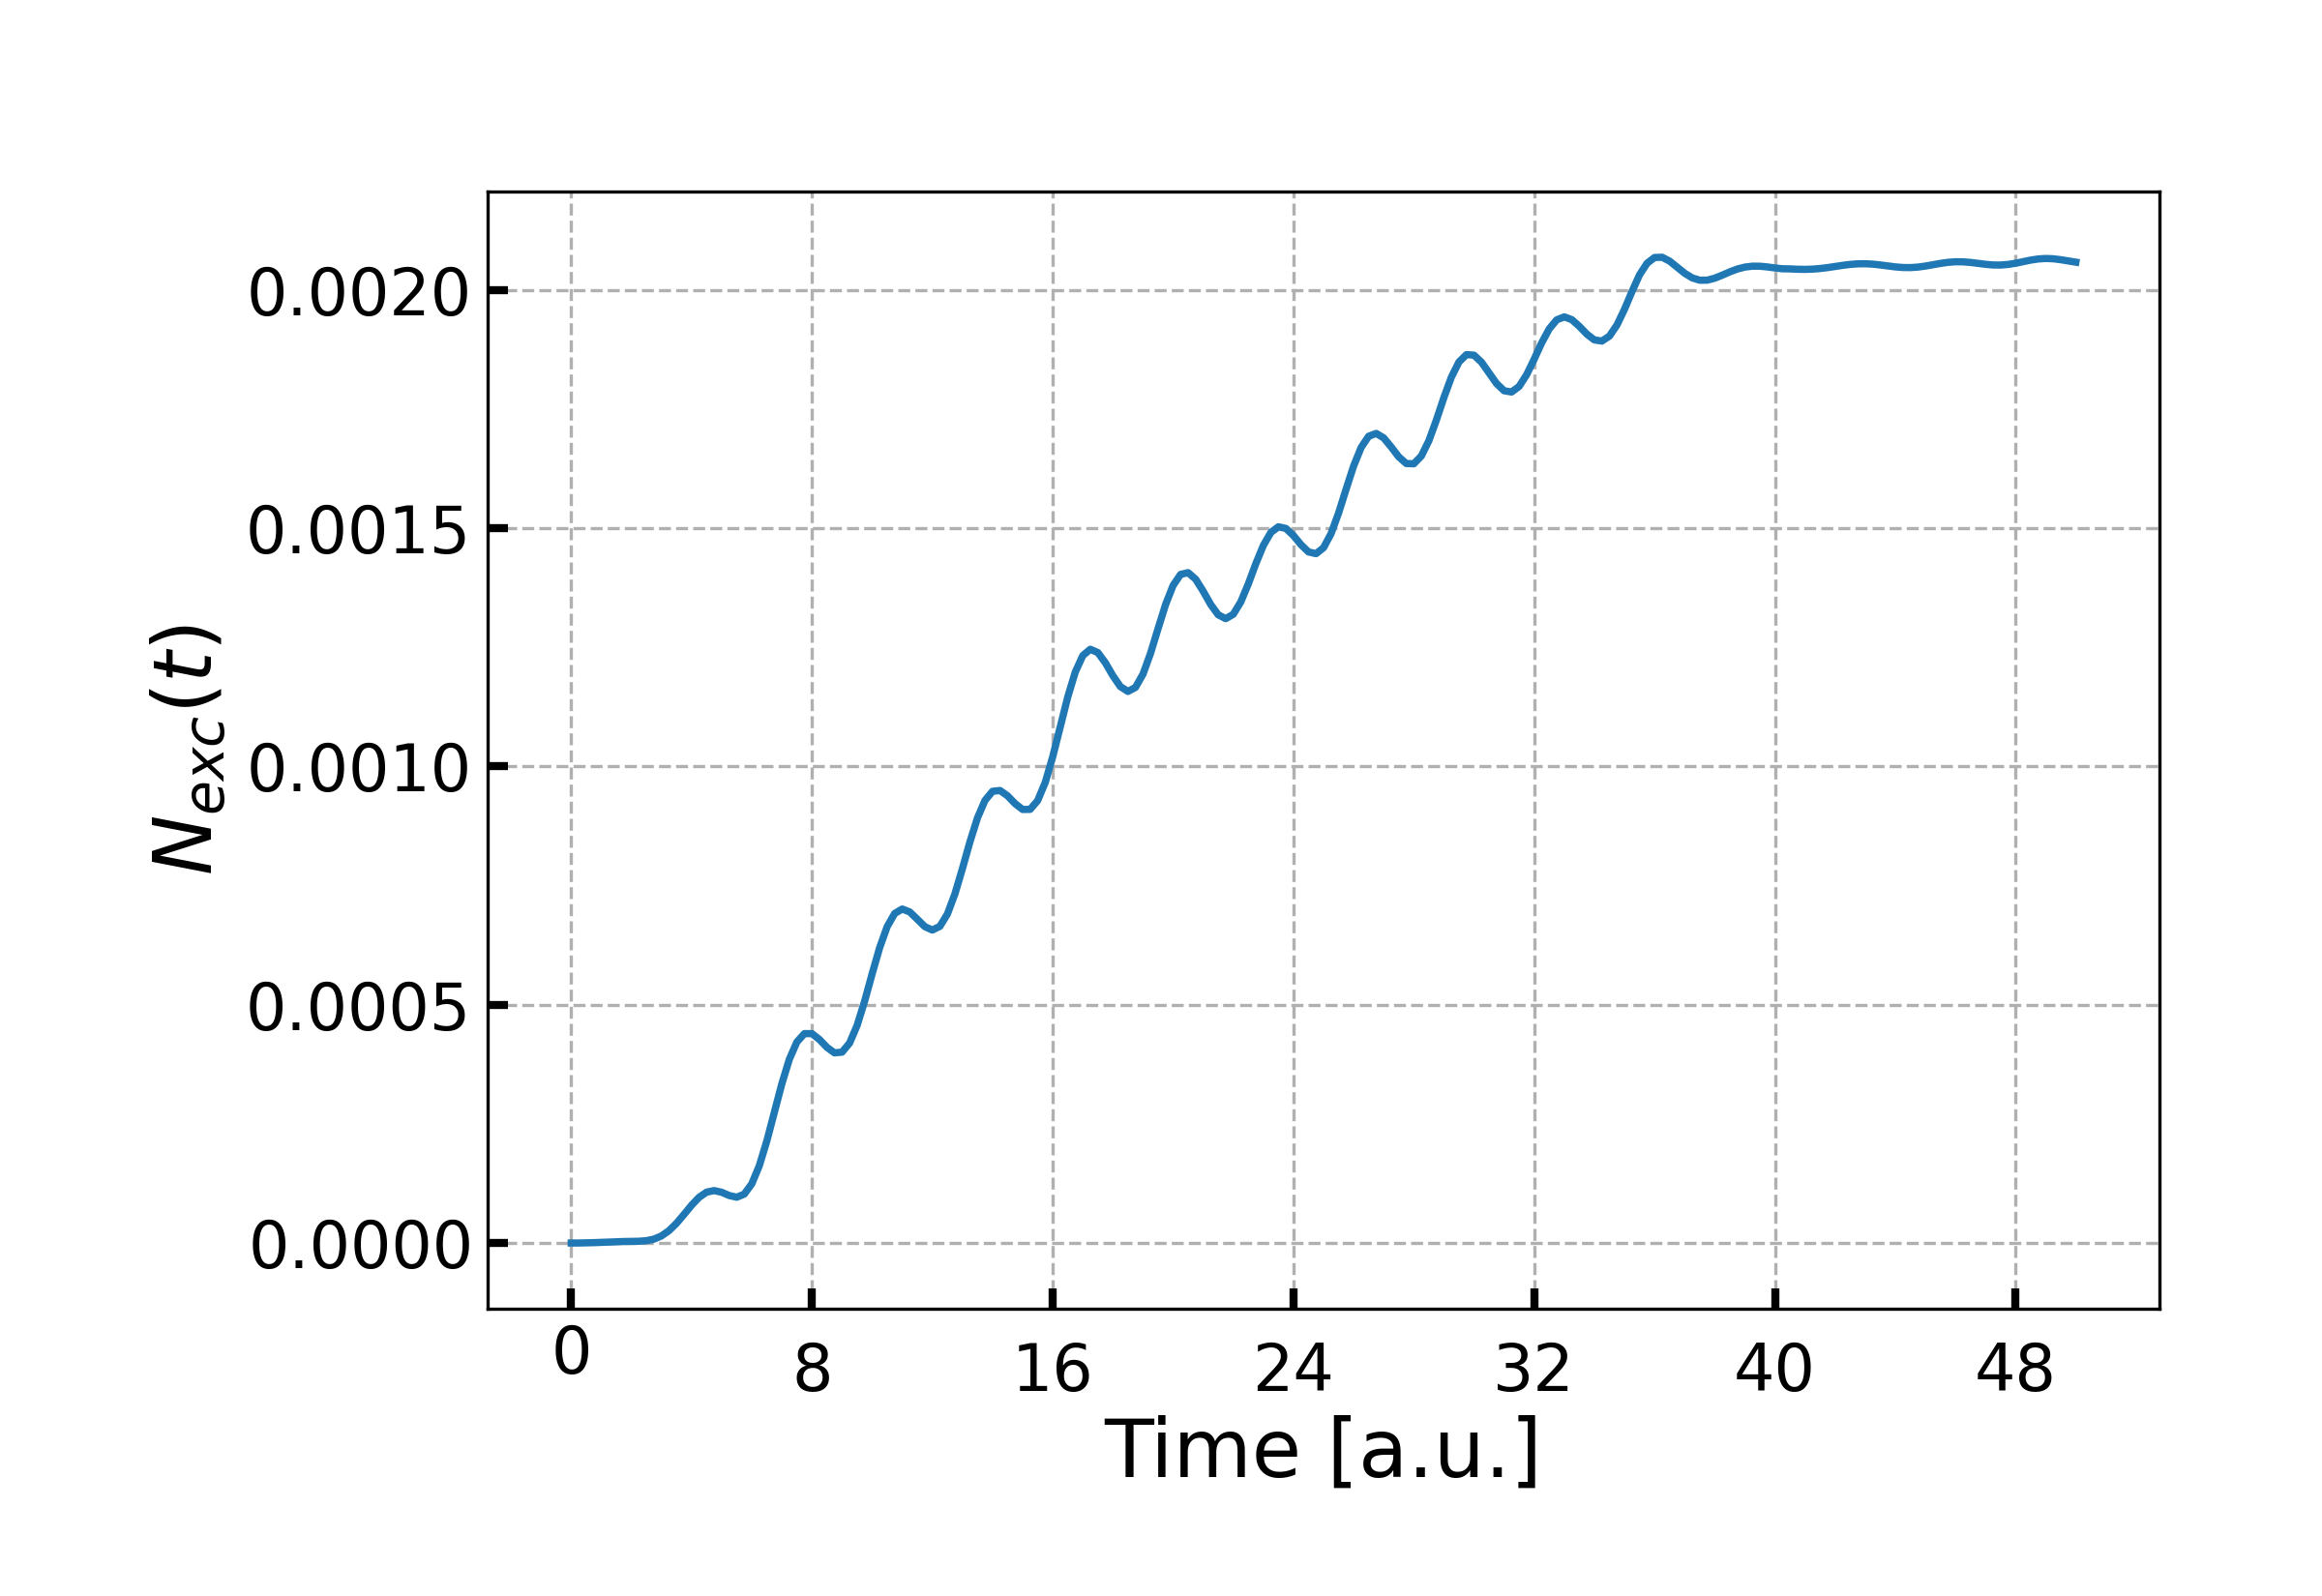" width="500" align="left"/>
</figure>

<a id='5'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">5. Converging the results</span>

If you intend to obtain high-quality results, it is necessary to converge them with respect to a proper set of reliable parameters. In **RT-TDDFT**, typically they are:

- <code><span style="color:mediumblue">ngridk</span></code>
- <code><span style="color:mediumblue">rgkmax</span></code>
- local-orbitals

What regards the time-step, calculations are typically not too sensitive to it. Usually, there is a critical value $t_{cr}$ and when the employed time-step is larger than $t_{cr}$, a sort of divergence is observed. However, below tcr the results tend to be very similar and almost independent of the time-step (see discussion in **[<span style="color:firebrick">Ref.[1]</span>](#7)**).

Below is, e.g., the current density for a finer **k**-grid of **16×16×16** points compared to **4×4×4** as used in this tutorial (see **[<span style="color:firebrick">Ref.[5]</span>](#7)**):

<figure>
<img src=" 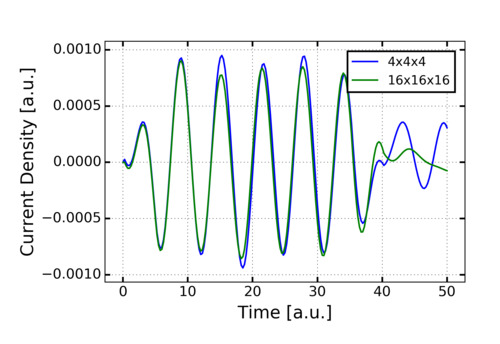" width="500" align="left"/>
</figure>

<a id='6'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">6. Other Expressions for the Laser Field</span>

Apart from a cosine function modulated by a trapezoid, as considered in this tutorial, it is also possible the following fields:

- an impulse (delta-kick)
- a cosine with a sin squared as envelope (which mimics a laser with a Gaussian envelope, employed in many experiments).

These other functions are explored in the tutorials **Simulating pump-probe spectroscopy with RT-TDDFT** and **Studying higher-harmonic generation using RT-TDDFT**.

**<span style="color:#15317E">Impulsive Function</span>**

In this case, the field is

\begin{equation}
\tag{10}
\mathbf{A}(t) = \left\{ \begin{array}{ll} 0 & t < t_0-w \\ -c\,\mathbf{E}_0 \frac{1}{16} \left( \frac{t+t_0}{w} +1 \right)^{\!\!3} \left[ 3\left( \frac{t-t_0}{w} \right)^{\!\!2} - 9\left( \frac{t-t_0}{w} \right) + 8 \right] \quad & t_0-w \le t \le t_0+w \\ -c\,\mathbf{E}_0 & t > t_0 + w \end{array} \right.
\end{equation}

The next figure depicts the vector potential as a function of time.

<figure>
<img src=" 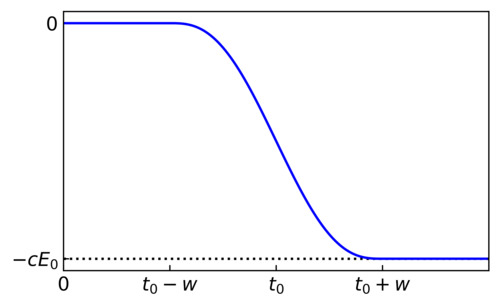" width="500" align="left"/>
</figure>

The electric field is

\begin{equation}
\tag{11}
\mathbf{E}(t) = -\frac{1}{c}\frac{d \mathbf{A} }{dt} = \left\{ \begin{array}{ll} \mathbf{E}_0 \frac{15}{16} \left( \frac{t-t_0}{w} +1 \right)^{\!\!2} \left( \frac{t-t_0}{w} -1 \right)^{\!\!2} & t_0 - w \le t_0 + w \\ 0 & t < t_0-w \mbox{ or } t > t_0+w \end{array} \right.
\end{equation}

This is schematically shown in the figure bellow.

<figure>
<img src=" 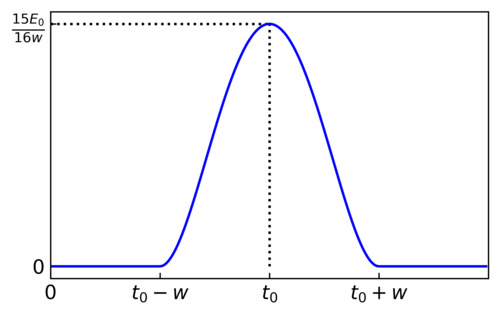" width="500" align="left"/>
</figure>

With the figure, it is ease to verify that this function converges to $\mathbf{E}_0 \,\delta(t-t_0)$ in the limit $w \to 0$. It is also possible to specify $w=0$. In this case, the vector potential is equal to 0, for times not larger than t0. And for the smallest time larger than $t_0$, the vector potential assumes a value of $-c\,\mathbf{E}_0$ (this smallest time depends clearly on the time-step employed in the calculation).

The corresponding entry for this field in the **input.xml** file is

```xml
...
         <laser>
            <kick t0="1.d0" width="0.1d0" amplitude="0.01d0" direction="z"/>
         </laser>
...
```

The meaning of the parameters is:

- $t_0$ is specified by the attribute <code><span style="color:mediumblue">t0</span></code>;
- the width of the impulse function, $w$, is specified by the attribute <code><span style="color:mediumblue">width</span></code>;
- the attribute <code><span style="color:mediumblue">amplitude</span></code> determines the amplitude $E_0$;
- the attribute <code><span style="color:mediumblue">direction</span></code> defines the direction of the field.

<a id='6.1'></a>
**<span style="color:#15317E">Cosine Modulated by a Sin Squared</span>**

In this case, the field has the same expression as in Eq. (8), but with the envelope given as

\begin{equation}
\tag{12}
f(t) = \left\{ \begin{array}{ll} 0 , & t \le t_0 \quad\mbox{ or }\quad t \ge t_0 + w \\ \sin^2( \pi(t-t_0)/w)\quad & t_0 \le t \le t_0 + w \\ \end{array} \right.
\end{equation}

The following figure illustrates the considered field

<figure>
<img src=" 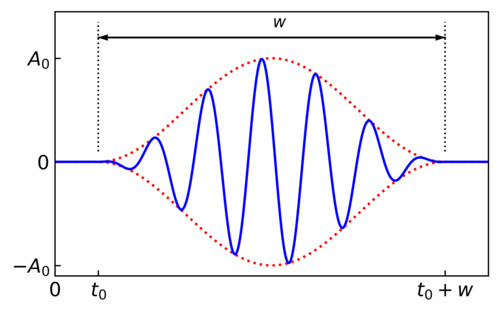" width="500" align="left"/>
</figure>

The parameter $w$ determines the width of the pulse, whereas $t_0$, the instant at which the pulse is applied.

The entry for this field in **input.xml** is

```xml
...
        <laser>
            <sinSq 
               t0="0.5d0" omega="1.d0" phase="0.d0" 
               amplitude="1.0d0" pulseLength="5.d0" direction="y"/>
        </laser>
...
```

The meaning of the parameters is:

- $t_0$ is specified by the attribute <code><span style="color:mediumblue">t0</span></code>;
- the angular frequency $\omega$ and phase, given in Eq. (8) are determined by the attributes <code><span style="color:mediumblue">omega</span></code> and <code><span style="color:mediumblue">phase</span></code>, respectively;
- the width of the pulse, $w$, is specified by the attribute <code><span style="color:mediumblue">pulseLength</span></code>;
- the attribute <code><span style="color:mediumblue">amplitude</span></code> determines the amplitude $A_0$, as given in Eq. (8);
- the attribute <code><span style="color:mediumblue">direction</span></code> defines the direction of the field.

<a id='6.2'></a>
**<span style="color:#15317E">Combining Fields</span>**

It is possible to combine fields by adding more elements to <code><span style="color:green">laser</span></code> element. Actually, all the entries in this element are added up to build the resulting vector potential. To use the example considered in this tutorial, this entry:

```xml
...
        <laser>
            <trapCos 
               amplitude="1.0d0" omega="1.0d0" phase="0.d0"
               t0="0.25d0" riseTime="5.d0" width="30.d0" direction="x" />
            <trapCos 
               amplitude="1.0d0" omega="1.0d0" phase="0.d0"
               t0="0.25d0" riseTime="5.d0" width="30.d0" direction="y" />
         </laser>
...
```

will produce a resulting field $\mathbf{A}(t) = A_\textrm{tutorial}(t)\,\hat{x}+A_\textrm{tutorial}(t)\,\hat{y}$, where we are using here $A_\textrm{tutorial}$ to denote the field employed in this tutorial. Here we are using the same field and different directions. But it is also possible to combine different kinds of fields. 

<a id='7'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">Reference</span>

The details on the implementation of real-time RT-TDDFT within the exciting code can be found in **[<span style="color:firebrick">Ref.[1]</span>](#7)**.
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">Bibliography</span>

1. Ronaldo Rodrigues Pela, Claudia Draxl. "All-electron full-potential implementation of real-time **TDDFT** in exciting" (**[link](https://iopscience.iop.org/article/10.1088/2516-1075/ac0c26)**).
2. In general, it is a good practice break the **k**-mesh off symmetry by modifying the <code><span style="color:mediumblue">vkloff</span></code> attribute (see discussion in **[<span style="color:firebrick">Ref.[1]</span>](#7)**). We also recommend to set <code><span style="color:mediumblue">nosym</span>=<span style="color:firebrick">"true"</span></code> and <code><span style="color:mediumblue">reducek</span>=<span style="color:firebrick">"false"</span></code> inside the element <code><span style="color:green">xs</span></code>.
3. More information about the script **`excitingscripts.plot.multitask`** can be found **[here](https://www.exciting-code.org/home/the-python-script-plot.multitask)**.
4. The (total) vector potential $\mathbf{A}(t)$, appearing in the Hamiltonian Eq. (1), is a sum

\begin{equation}
\tag{13}
\mathbf{A}(t) = \mathbf{A}_\textrm{ext}(t)+\mathbf{A}_\textrm{ind}(t),
\end{equation}

where $\mathbf{A}_\textrm{ext}(t)$ and $\mathbf{A}_\textrm{ind}(t)$ are the external and induced vector potentials, respectively. On the one hand, the external is related to the displacement field $\mathbf{D}(t)$ as: 

\begin{equation}
\tag{14}
\mathbf{A}_\textrm{ext}(t) = -c\int_0^t \mathbf{D}(t')\, dt'
\end{equation}

On the other hand, the induced vector potential, $\mathbf{A}_\textrm{ind}(t)$, is obtained from the current density as

\begin{equation}
\tag{15}
\frac{d^2\mathbf{A}_\textrm{ind}}{dt^2} = 4 \pi c\, \mathbf{J}(t).
\end{equation}

5. Assuming that you performed a new calculation for a **k**-grid of **16×16×16** in a subfolder **kpt16** inside the folder **run_diamond_rt**, and that your current directory is **run_diamond_rt**, then the following command can be used to plot two current densities

```bash
python3 -m excitingscripts.plot.multitask --jind -f JIND.OUT kpt16/JIND.OUT --x -c '4x4x4' '16x16x16'
```


<hr style="border:2px solid #DDD"> </hr>